In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
# df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
# X = df.drop("target", axis=1) 
# y = df['target']

# from sklearn.dummy import DummyClassifier 
# model= DummyClassifier().fit(X,y)

# X_test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
# y_pred= model.predict(X_test)

# submission= pd.DataFrame({"id": range(0,X_test.shape[0]), 
#                           'target': y_pred})

# submission.to_csv ('submission.csv',index=False)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
# loading the data
df =  pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")

# missing values
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [5]:
df.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [6]:
#  Date Transformation
df['last contact date'] = pd.to_datetime(df['last contact date'])
df['contact_year'] = df['last contact date'].dt.year
df['contact_month'] = df['last contact date'].dt.month
df['contact_day'] = df['last contact date'].dt.day
df['contact_weekday'] = df['last contact date'].dt.weekday
df.drop('last contact date', axis=1, inplace=True)

In [7]:

#  filling missing values with the most common value (mode)
df['job'] = df['job'].fillna(df['job'].mode()[0])
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['contact'] = df['contact'].fillna(df['contact'].mode()[0])
df['poutcome'] = df['poutcome'].fillna(df['poutcome'].mode()[0])

In [8]:


# Feature Transformation for `job` (Frequency Encoding)
job_counts = df['job'].value_counts(normalize=True)
df['job_freq'] = df['job'].map(job_counts)
df.drop('job', axis=1, inplace=True)

#  Binning Continuous Features
df['age_bin'] = pd.cut(df['age'], bins=[18, 30, 45, 60, 80], labels=['18-30', '30-45', '45-60', '60-80'])
df.drop('age', axis=1, inplace=True)

df['balance_bin'] = pd.qcut(df['balance'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
df.drop('balance', axis=1, inplace=True)

#   Interaction Features
df['financial_status'] = df['housing'] + '_' + df['loan']

#  Label Encoding for Binary Features
binary_cols = ['default', 'housing', 'loan', ]
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])



#  OneHot Encoding for Multi-Categorical Columns
df = pd.get_dummies(df, columns=['education', 'marital', 'contact', 'poutcome', 'financial_status', 'age_bin', 'balance_bin'], drop_first=True)

#  Feature Scaling for Numerical Features
scaler = StandardScaler()
num_features = ['duration', 'campaign', 'pdays', 'previous']
df[num_features] = scaler.fit_transform(df[num_features])

In [9]:
df.head()

,default,housing,loan,duration,campaign,pdays,previous,target,contact_year,contact_month,...,poutcome_success,financial_status_no_yes,financial_status_yes_no,financial_status_yes_yes,age_bin_30-45,age_bin_45-60,age_bin_60-80,balance_bin_Medium,balance_bin_High,balance_bin_Very High
0,0,1,0,-0.106702,-0.314334,1.607699,-0.245271,no,2009,4,...,False,False,True,False,False,False,False,False,True,False
1,0,1,0,-0.362850,-0.415446,-0.455175,-0.267926,no,2009,10,...,False,False,True,False,False,True,False,False,True,False
2,0,0,0,-0.147009,-0.415446,-0.455175,-0.267926,no,2010,11,...,False,False,False,False,True,False,False,False,True,False
3,0,1,0,-0.435663,-0.213222,-0.455175,-0.267926,no,2009,9,...,False,False,True,False,True,False,False,True,False,False
4,0,0,0,0.007720,-0.314334,-0.455175,-0.267926,no,2008,1,...,False,False,False,False,True,False,False,True,False,False


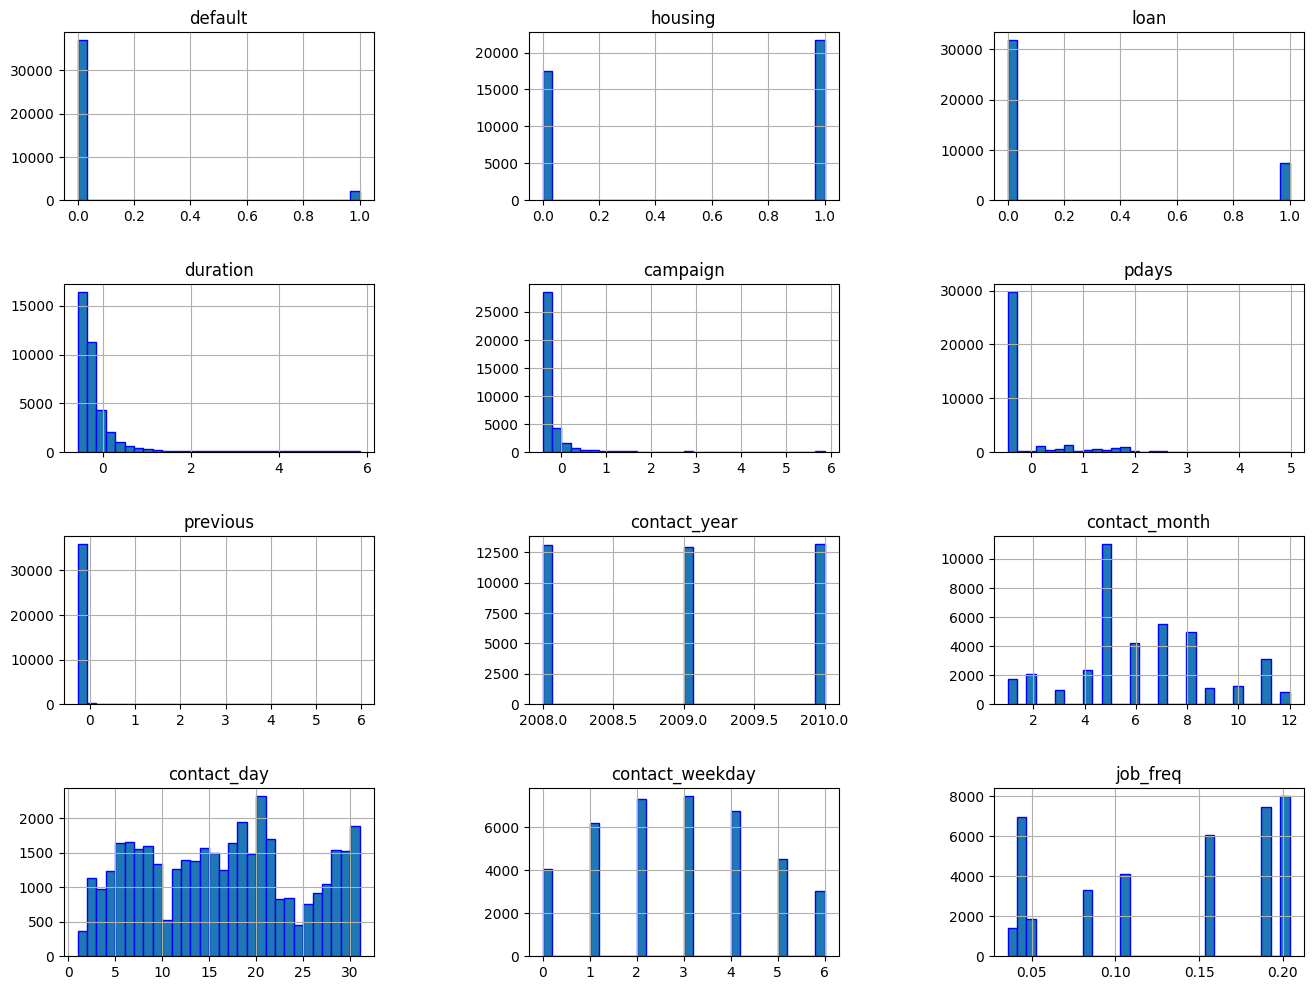

In [10]:
 import seaborn as sns 
import matplotlib.pyplot as plt

df.hist (bins=30, edgecolor ='blue', figsize=(16,12))

plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()


In [11]:
# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()


print(corr_matrix)


                  default   housing      loan  duration  campaign     pdays  \
default          1.000000 -0.019287  0.181860  0.458076  0.473876  0.376927   
housing         -0.019287  1.000000  0.026333 -0.026819 -0.038591  0.047196   
loan             0.181860  0.026333  1.000000  0.184147  0.192926  0.155936   
duration         0.458076 -0.026819  0.184147  1.000000  0.630944  0.527020   
campaign         0.473876 -0.038591  0.192926  0.630944  1.000000  0.519469   
pdays            0.376927  0.047196  0.155936  0.527020  0.519469  1.000000   
previous         0.493975 -0.027160  0.206297  0.683951  0.689211  0.586175   
contact_year     0.000564 -0.001198  0.007263 -0.006046  0.003603  0.003803   
contact_month    0.060794 -0.146845  0.042864  0.076369  0.100006  0.017340   
contact_day     -0.010494 -0.031488  0.006346 -0.020428  0.030812 -0.067052   
contact_weekday  0.019326  0.008523  0.013826  0.018270  0.032570 -0.017579   
job_freq        -0.236831  0.136390 -0.097724 -0.331

In [12]:
# Split Data
X = df.drop('target', axis=1)
y = df['target']

# Encode the target variable ('yes'/'no') to binary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
#model 1( main model)
# Model Training with XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_classifier.fit(X_train, y_train)


model1=xgb_classifier.fit(X_train, y_train)
# Model Evaluation
y_pred = xgb_classifier.predict(X_test)
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")
print(classification_report(y_test, y_pred))

F1 Score (macro): 0.7424908908984501
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6677
           1       0.60      0.52      0.56      1166

    accuracy                           0.88      7843
   macro avg       0.76      0.73      0.74      7843
weighted avg       0.87      0.88      0.87      7843



In [15]:
#from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',  # Choosing the scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the tuned model
y_pred = best_model.predict(X_test)
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
F1 Score (macro): 0.7354320138365908
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      6677
           1       0.60      0.49      0.54      1166

    accuracy                           0.88      7843
   macro avg       0.76      0.72      0.74      7843
weighted avg       0.87      0.88      0.87      7843



In [16]:

# model 2
#  Logistic Regression model

logreg_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Training the model using the training data
logreg_classifier.fit(X_train, y_train)

model2=logreg_classifier.fit(X_train, y_train)
# Model Evaluation
y_pred = logreg_classifier.predict(X_test)
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")
print(classification_report(y_test, y_pred))

F1 Score (macro): 0.6388936896881694
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6677
           1       0.60      0.25      0.35      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.61      0.64      7843
weighted avg       0.84      0.86      0.84      7843



In [17]:


# model 3

#  Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)


rf_classifier.fit(X_train, y_train)


model3=rf_classifier.fit(X_train, y_train)
# Model Evaluation
y_pred = logreg_classifier.predict(X_test)
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")
print(classification_report(y_test, y_pred))

F1 Score (macro): 0.6388936896881694
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6677
           1       0.60      0.25      0.35      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.61      0.64      7843
weighted avg       0.84      0.86      0.84      7843



In [18]:
# Loading the test dataset
test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

In [19]:
# Loading the test dataset
test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

#  Date Transformation for test_df
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'])
test_df['contact_year'] = test_df['last contact date'].dt.year
test_df['contact_month'] = test_df['last contact date'].dt.month
test_df['contact_day'] = test_df['last contact date'].dt.day
test_df['contact_weekday'] = test_df['last contact date'].dt.weekday
test_df.drop('last contact date', axis=1, inplace=True)

#  Fill Missing Values with Mode for test_df
test_df['job'] = test_df['job'].fillna(test_df['job'].mode()[0])
test_df['education'] = test_df['education'].fillna(test_df['education'].mode()[0])
test_df['contact'] = test_df['contact'].fillna(test_df['contact'].mode()[0])
test_df['poutcome'] = test_df['poutcome'].fillna(test_df['poutcome'].mode()[0])

#  Feature Transformation for `job` (Frequency Encoding) for test_df
test_df['job_freq'] = test_df['job'].map(job_counts)
test_df.drop('job', axis=1, inplace=True)

#  Binning Continuous Features for test_df
test_df['age_bin'] = pd.cut(test_df['age'], bins=[18, 30, 45, 60, 80], labels=['18-30', '30-45', '45-60', '60-80'])
test_df.drop('age', axis=1, inplace=True)

test_df['balance_bin'] = pd.qcut(test_df['balance'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
test_df.drop('balance', axis=1, inplace=True)

#  Creating Interaction Features for test_df
test_df['financial_status'] = test_df['housing'] + '_' + test_df['loan']

#  Label Encoding for Binary Features
binary_cols = ['default', 'housing', 'loan',]
le = LabelEncoder()
for col in binary_cols:
    test_df[col] = le.fit_transform(test_df[col])

#  OneHot Encoding for Multi-Categorical Columns in test_df
test_df = pd.get_dummies(test_df, columns=['education', 'marital', 'contact', 'poutcome', 'financial_status', 'age_bin', 'balance_bin'], drop_first=True)

# Aligning test_df with training set columns
missing_cols = set(test_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Add missing columns as zero



#  Feature Scaling for Numerical Features in test_df
test_df[num_features] = scaler.transform(test_df[num_features])

In [20]:


test_predictions = model1.predict(test_df)

# predictions back to 'yes'/'no'
test_predictions = label_encoder.inverse_transform(test_predictions)

# Creating the submission DataFrame 
submission = pd.DataFrame({'id': test_df.index, 'target': test_predictions})
submission.to_csv('submission.csv', index=False)